In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
plt.rcParams['figure.figsize'] = [17, 8]

In [2]:
import torch
from torch.utils.data import DataLoader

In [3]:
from dataset.audio_dataset import AudioData, default
from model.autoencoder.encoder import Encoder
from model.autoencoder.decoder import Decoder
from model.ddsp.harmonic_oscillator import OscillatorBank
from train.train import AutoEncoder
from config.default import Config

In [4]:
default = Config()

In [5]:
dataset = AudioData(clear=False)

Loading presaved dataset...


In [6]:
audio = dataset[0]
audio.shape

torch.Size([88064])

In [7]:
loader = DataLoader(dataset, 10, shuffle=True)

In [8]:
for batch in loader:
    print(batch.shape)
    break

torch.Size([10, 88064])


In [9]:
batch = batch

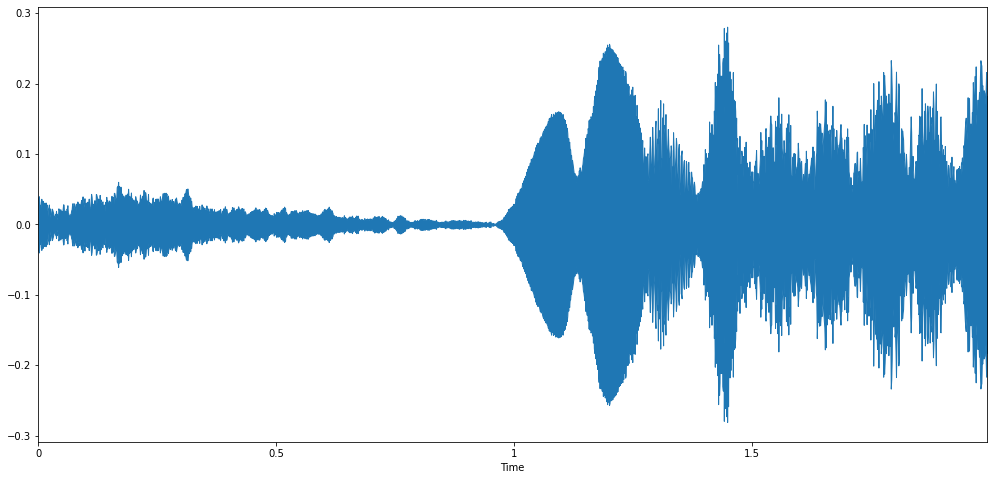

In [10]:
librosa.display.waveplot(batch[0].cpu().numpy(), sr=default.sample_rate)

In [11]:
ipd.Audio(data=batch[0].cpu().numpy(), rate=default.sample_rate)

In [12]:
encoder = Encoder()

In [13]:
z = encoder(batch)

In [14]:
z['probabilities'].shape

torch.Size([10, 169, 360])

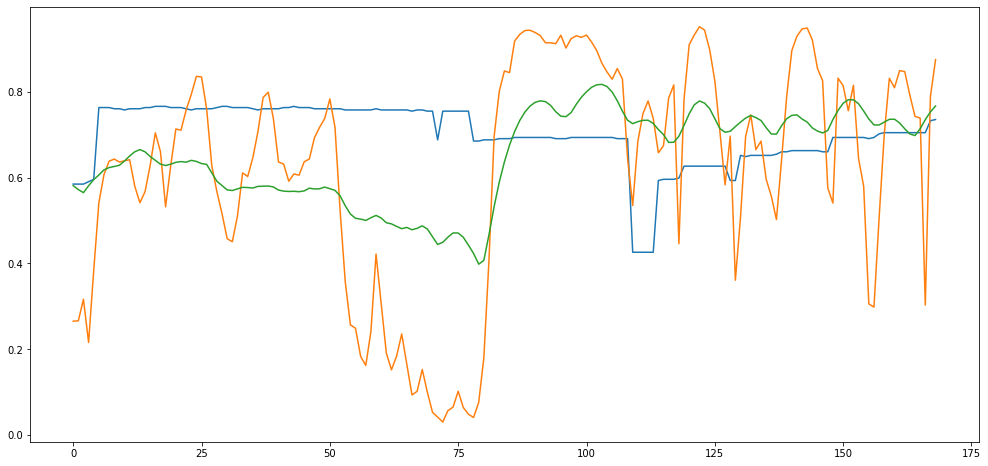

In [15]:
plt.plot(z['normalized_cents'][0].cpu().numpy())
plt.plot(z['harmonicity'][0].cpu().numpy())
plt.plot(z['loudness'][0].cpu().numpy())

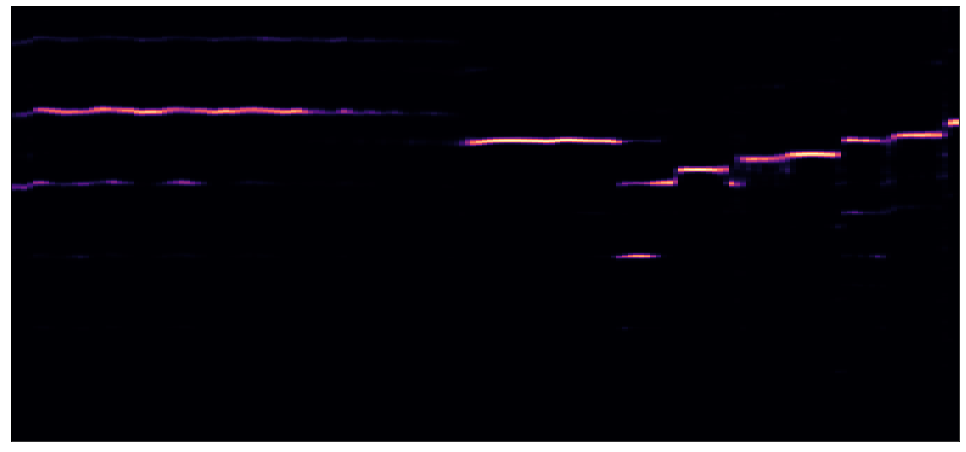

In [16]:
librosa.display.specshow(z['probabilities'][0].cpu().numpy().T, sr=default.sample_rate, hop_length=default.hop_length)

In [17]:
ae = AutoEncoder()

In [18]:
with torch.no_grad():
    result_hat = ae(batch)

In [19]:
decoder = Decoder()

In [20]:
with torch.no_grad():
    z_hat = decoder(z)

In [21]:
with torch.no_grad():
    z = encoder(result_hat)

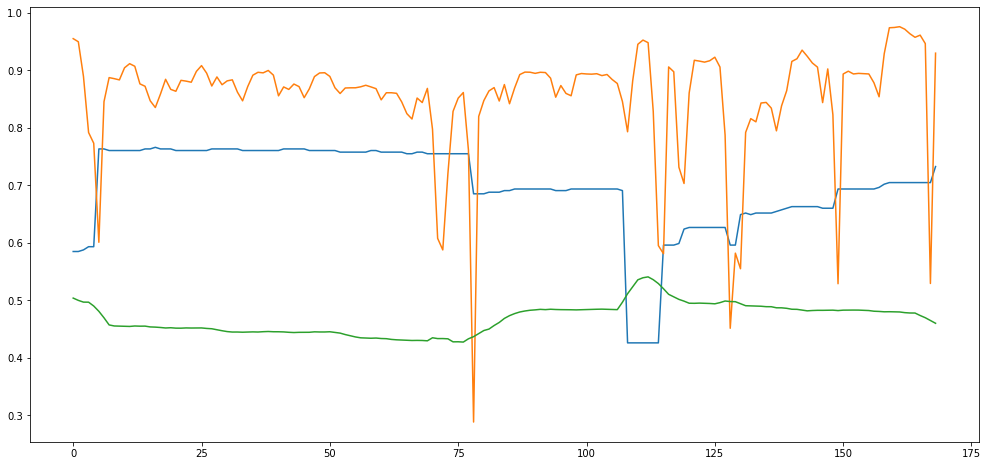

In [22]:
plt.plot(z['normalized_cents'][0].cpu().numpy())
plt.plot(z['harmonicity'][0].cpu().numpy())
plt.plot(z['loudness'][0].cpu().numpy())

In [23]:
ipd.Audio(data=result_hat[0].cpu().numpy(), rate=default.sample_rate)

In [24]:
from crepe.hidden_markov_model import HiddenMarkovModel

ModuleNotFoundError: No module named 'crepe.hidden_markov_model'

In [ ]:
# uniform prior on the starting pitch
starting = torch.ones(360) / 360

# transition probabilities inducing continuous pitch
xx, yy = torch.meshgrid(torch.arange(360), torch.arange(360))
transition = torch.maximum(12 - abs(xx - yy), torch.zeros_like(xx))
transition = transition / torch.sum(transition, dim=1, keepdims=True)

# emission probability = fixed probability for self, evenly distribute the
# others
self_emission = 0.1
emission = (torch.eye(360) * self_emission + torch.ones((360, 360)) *
            ((1 - self_emission) / 360))

In [ ]:
model = HiddenMarkovModel(transition, emission, starting)

In [ ]:
states_seq, state_prob = model.viterbi_inference(z['probabilities'][0].argmax(dim=-1))

In [ ]:
plt.plot(z['normalized_cents'][0].cpu().numpy())
plt.plot(states_seq.cpu().numpy() / 359)

In [ ]:
states_seq.shape